# Extract text from pdf document: 10.NMSA_Guidelines_English

In [1]:
#! pip install pytesseract
#!pip install Pillow
#!pip install -U numpy

In [22]:
from PIL import Image
from wand.image import Image as wimage
import os
import io
import pytesseract
import numpy as np
import re
from itertools import islice
from functools import reduce
import string

class Document:
    def __init__(self, path, titles = None):
        self.path = path
        self.name = self.path
    
    def get_images(self):
        page_images = []
        with wimage(filename=self.path, resolution=200) as img:
            for page_wand_image_seq in img.sequence:
                page_wand_image = wimage(page_wand_image_seq)
                page_jpeg_bytes = page_wand_image.make_blob(format="jpeg")
                page_jpeg_data = io.BytesIO(page_jpeg_bytes)
                page_image = Image.open(page_jpeg_data)
                page_images.append(page_image)
        self.images = page_images
        
    def process_images(self):
        self.text = np.array([pytesseract.image_to_string(x) for x in self.images])
        self.pages = [x for x in range(len(self.images))]
        
    def split_lines(self):
        self.lines = {}
        counter = 0
        pages = [re.split('\n', self.text[i]) for i in self.pages]
        for x, page in enumerate(pages):
            for i, line in enumerate(page):
                self.lines[i + counter] = [line, x]
            counter += len(page)
    
    def remove_titles(self):
        titles = [x for x in list(self.lines.keys()) if self.lines[x][0].lower() != self.lines[x][0] and\
                  len(self.lines[x][0]) <= 50]
        titles = [x for x in titles if self.lines[max(0, x - 1)][0].endswith('.') or\
                  self.lines[max(0, x - 1)][0] == '']
        print("Removing {} titles".format(len(titles)))
        for x in titles:
            del self.lines[x]
        self.lines = { key : value for key, value in zip(range(len(self.lines)), self.lines.values())}
        
    def combine_sentences(self):
        self.paragraphs = []
        ends = [0] + [i + 1 for i in self.lines.keys() if self.lines.get(i)[0].endswith('.')]
        sentence_ids = [(val, ends[x + 1]) for x, val in enumerate(ends) if val < max(ends)]
        for i in sentence_ids:
            lines = [self.lines.get(x)[0] for x in range(i[0], i[1])]
            self.paragraphs.append(' '.join(' '.join(lines).split()))
            
    def remove_headers(self):
        words = [x.replace(".pdf", "") for x in self.path.replace("/", " ").split(" ") if x not in ["..", "data", "raw"]]
        locs = []
        for i in reversed(range(3, len(words) + 1)):
            for x in window(words, n = i):
                locs.append(' '.join(x))

        self.clean = [reduce(lambda item, loc: item.replace(loc,''), [item]+locs)
            for item in self.paragraphs]
        
    def clean_data(self):
        self.clean = [re.sub("[\(\[].*?[\)\]]", "", x).lower() for x in self.clean]
        self.clean = [x.translate(str.maketrans('', '', string.punctuation)) for x in self.clean]
        
    def export_data(self):
        self.export_path = self.path.replace("raw", "processed")
        self.export_path = self.export_path.replace(".pdf", ".txt")
        with open(self.export_path, "w") as text_file:
            for x in self.clean:
                text_file.write(x)
                text_file.write('\n')

### # In doc1,punctuations were removed

In [ ]:
filepath = "D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/raw/india/10.NMSA_Guidelines_English.pdf"
doc1 = Document(filepath)
# get_image这里出现过error，需要安装Ghostscript
doc1.get_images()

# !pip install tesseract
# !pip install pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

doc1.process_images()
print("Images processed")

doc1.split_lines()
doc1.remove_titles()
doc1.combine_sentences()
print("Sentences combined")

def window(seq, n):
            "Returns a sliding window (of width n) over data from the iterable"
            "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
            it = iter(seq)
            result = tuple(islice(it, n))
            if len(result) == n:
                yield result
            for elem in it:
                result = result[1:] + (elem,)
                yield result
doc1.remove_headers()
doc1.clean_data()
print("Text cleaned")

doc1.export_data()
print("Exported data to: {}".format(doc1.export_path))

In [ ]:
# this document was transfered to txt/csv with 394 rows

### # In doc2,punctuations were remained

In [55]:
filepath = "D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/raw/india/10.NMSA_Guidelines_English.pdf"
doc2 = Document(filepath)
# get_image这里出现过error，需要安装Ghostscript
doc2.get_images()

# !pip install tesseract
# !pip install pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

doc2.process_images()
print("Images processed")

doc2.split_lines()
doc2.remove_titles()
doc2.combine_sentences()
print("Sentences combined")

def window(seq, n):
            "Returns a sliding window (of width n) over data from the iterable"
            "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
            it = iter(seq)
            result = tuple(islice(it, n))
            if len(result) == n:
                yield result
            for elem in it:
                result = result[1:] + (elem,)
                yield result
doc2.remove_headers()
# doc2.clean_data()
print("Text cleaned")

doc2.export_data()
print("Exported data to: {}".format(doc1.export_path))

Images processed
Removing 441 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English.txt


# Reload the un-cleaned CSV file

In [242]:
corpus = open("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English.txt", "r").read()

In [204]:
# difficulty 1: there are serial numbers in the whole document as well as pages numbers of each part in the catelog page.
# and it is hard to throw these numbers.
# difficulty 2: the text extracted from pdf is not clear. e.g.
# "chapter  1 sustainable agriculture namiowat mision ron sustawanis acrcuirune orenamiona gudeunes national mission for sustainable agriculture"

In [243]:
len(corpus)

138866

# NLP pipeline

In [205]:
# 1. Use re (regular expression) package to find all matches of amounts in the article
'''
import re
print('amounts:')
print(re.findall('\d*\.?\d+?', corpus))
'''
# Difficulty: more rules should be set to extract the numbers related to financial incentives

In [206]:
# 2. Substitute all numbers with # character and print the output

# is it feasible if I replace numbers with '#'?

#print(re.sub(r'[0-9]','#',corpus))

In [207]:
# 3. Use NTLK and/or Spacy (Links to an external site.) tokenization features to:
'''
import nltk
nltk.download('punkt')
# Tokenize sentences and words
from nltk import word_tokenize, sent_tokenize, ngrams, pos_tag, RegexpParser
from collections import Counter
tokens_all=word_tokenize(corpus)
print(tokens_all)
'''

In [208]:
'''
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from nltk.stem.porter import PorterStemmer
'''

"\nnltk.download('stopwords')\nfrom nltk.corpus import stopwords\n\nnltk.download('wordnet')\nfrom nltk.stem import WordNetLemmatizer\n\nfrom nltk.stem.porter import PorterStemmer\n"

In [209]:
'''
# 4. Remove all English stop words
stop_words = set(stopwords.words('english')) 
filtered_words = [] 

# 5. Lemmatize and deduplicate unigrams into a dictionary
# using Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
dedup=[]
#porter_stemmer=PorterStemmer()
#dedup2=[]

for w in tokens_all: 
    if w not in stop_words: 
        filtered_words.append(w) 
        dedup.append(wordnet_lemmatizer.lemmatize(w))
        #dedup2.append(porter_stemmer.stem(w))
# print('After removing all English stop words: \n',filtered_words,'\n')
print('After removing all English stop words: \n','Length of the filtered words: \n',len(filtered_words),'\n')
print('Lemmatizing and deduplicating unigrams into a dictionary: \n','Length of the dictionary: ',len(dedup),'\n')
#print('Stemming: \n','Length of the dictionary: ',len(dedup2),'\n')

print('The dictionary after lemmatizing: \n',dedup,'\n')
#print('The dictionary after Stemming: \n',dedup2,'\n')
'''

"\n# 4. Remove all English stop words\nstop_words = set(stopwords.words('english')) \nfiltered_words = [] \n\n# 5. Lemmatize and deduplicate unigrams into a dictionary\n# using Lemmatization\nwordnet_lemmatizer = WordNetLemmatizer()\ndedup=[]\n#porter_stemmer=PorterStemmer()\n#dedup2=[]\n\nfor w in tokens_all: \n    if w not in stop_words: \n        filtered_words.append(w) \n        dedup.append(wordnet_lemmatizer.lemmatize(w))\n        #dedup2.append(porter_stemmer.stem(w))\n# print('After removing all English stop words: \n',filtered_words,'\n')\nprint('After removing all English stop words: \n','Length of the filtered words: \n',len(filtered_words),'\n')\nprint('Lemmatizing and deduplicating unigrams into a dictionary: \n','Length of the dictionary: ',len(dedup),'\n')\n#print('Stemming: \n','Length of the dictionary: ',len(dedup2),'\n')\n\nprint('The dictionary after lemmatizing: \n',dedup,'\n')\n#print('The dictionary after Stemming: \n',dedup2,'\n')\n"

### # Text Tokens

In [58]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [59]:
# Our corpus is bigger than the default limit, we will set
# a new limit equal to its length.
nlp.max_length = len(corpus)
doc = nlp(corpus)

In [86]:
data_list = [["text","text_lower", "lemma", "lemma_lower","part_of_speech", "is_alphabet", "is_stopword"]]

for token in doc:
    data_list.append([token.text, token.lower_, token.lemma_, token.lemma_.lower(), token.pos_, token.is_alpha, token.is_stop])

# pos_:part of speech(predicted by statistical model)

import csv

csv.writer(open("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English_tokens.csv", "w", encoding="utf-8",
                newline="")).writerows(data_list)

### # Text Entities

In [87]:
data_list = [["text","text_lower", "label"]]

for ent in doc.ents:
    data_list.append([ent.text, ent.lower_, ent.label_])

csv.writer(open("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English_entities.csv", "w", encoding="utf-8",
                newline="")).writerows(data_list)

# the model was trained from Wikipedia

### # Text Sentences

In [68]:
# in this part I counted the number of positive and negative words per sentence.
# the english opinion lexicon was downloaded from <https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html>

with open("D:/personal/columbia university/capstone/opinion-lexicon-English/positive-words.txt", "r") as temp_file:
    positive_words = temp_file.read().splitlines()

with open("D:/personal/columbia university/capstone/opinion-lexicon-English/negative-words.txt", "r") as temp_file:
    negative_words = temp_file.read().splitlines()

In [88]:
# Now we will iterate over the doc.sents object and keep a score for each sentence and save the results to csv.
data_list = [["text", "score"]]

for sent in doc.sents:
    # Only take into account real sentences.
    if len(sent.text) > 10:
        score = 0
        # Start scoring the sentence.
        for word in sent:

            if word.lower_ in positive_words:
                score += 1

            if word.lower_ in negative_words:
                score -= 1

        data_list.append([sent.text, score])

csv.writer(open("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English_sentences.csv", "w", encoding="utf-8",
                newline="")).writerows(data_list)

# Plotting the Data

In [239]:
# set some custom colors that will apply globally to each plot.
sns.set(style="ticks",
    rc={
        "figure.figsize": [12, 7],
        "text.color": "white",
        "axes.labelcolor": "white",
        "axes.edgecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "axes.facecolor": "#5C0E10",
        "figure.facecolor": "#5C0E10"}
    )

### # Most Used Words

In [231]:
tokens = pd.read_csv("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English_tokens.csv")

In [232]:
tokens.head(10)

,text,text_lower,lemma,lemma_lower,part_of_speech,is_alphabet,is_stopword
0,NATIONAL,national,NATIONAL,national,PROPN,True,False
1,MISSION,mission,MISSION,mission,PROPN,True,False
2,FOR,for,for,for,ADP,True,True
3,SUSTAINABLE,sustainable,SUSTAINABLE,sustainable,PROPN,True,False
4,AGRICULTURE,agriculture,AGRICULTURE,agriculture,PROPN,True,False
5,ef,ef,ef,ef,PROPN,True,False
6,Ministry,ministry,Ministry,ministry,PROPN,True,False
7,of,of,of,of,ADP,True,True
8,Agriculture,agriculture,Agriculture,agriculture,PROPN,True,False
9,www.agricoop.nic.in,www.agricoop.nic.in,www.agricoop.nic.in,www.agricoop.nic.in,PROPN,False,False


In [233]:
# We will only take into account the top 20 alphabet tokens that are longer than 1 character and are not stop words.
words = tokens[(tokens["is_alphabet"] == True) & (tokens["is_stopword"] == False) & (
    tokens["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()[:25]

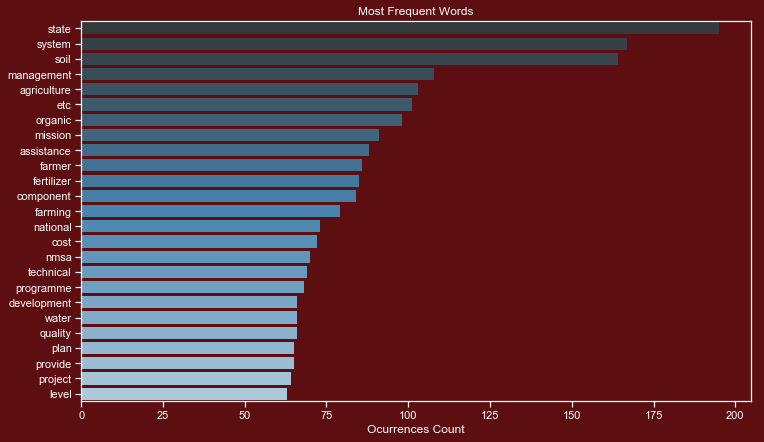

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=words.values, y=words.index, palette="Blues_d", linewidth=0)
plt.xlabel("Ocurrences Count")
plt.title("Most Frequent Words")
plt.show()

In [182]:
words

state          195
system         167
soil           164
management     108
agriculture    103
etc            101
organic         98
mission         91
assistance      88
farmer          86
fertilizer      85
component       84
farming         79
national        73
cost            72
nmsa            70
technical       69
programme       68
development     66
water           66
quality         66
plan            65
provide         65
project         64
level           63
Name: lemma_lower, dtype: int64

### # Sentiment Analysis

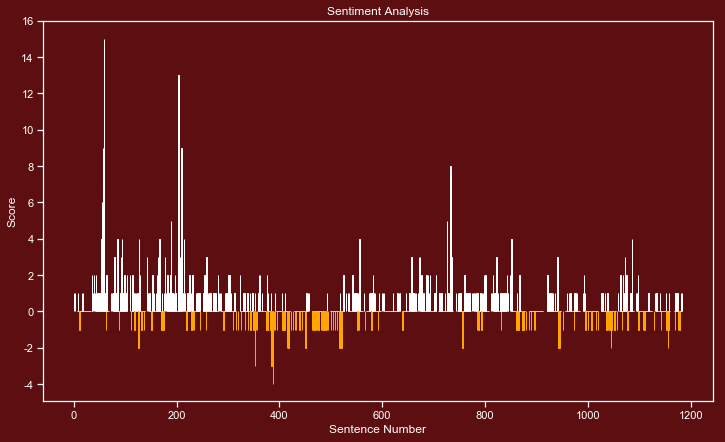

In [241]:
senti = pd.read_csv("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English_sentences.csv")
barplot=plt.bar(senti.index, senti["score"], color=(0.2, 0.4, 0.4, 1.0), linewidth=1)
for i in range(len(senti)):
    if senti["score"][i]<0:
        barplot[i].set_color('orange')
yticks_labels = ["{}".format(int(i)) for i in np.arange(-4, 18, 2)]
plt.yticks(np.arange(-4, 18, 2), yticks_labels)
plt.xlabel("Sentence Number")
plt.ylabel("Score")
plt.title("Sentiment Analysis")
plt.show()

# it is unrealiable to simply use sentiment words to tell the emotion of sentences.
# snorkel is a better way to do sentiment analysis, so in our next step, we will tune snorkel and keep using it.

# Extract text from pdf document: 1.PESA

In [211]:
filepath = "D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/raw/india/1.PESA.pdf"
doc = Document(filepath) # get_image这里出现过error，需要安装Ghostscript
doc.get_images()
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
doc.process_images()
print("Images processed")
doc.split_lines()
doc.remove_titles()
doc.combine_sentences()
print("Sentences combined")
def window(seq, n):
            "Returns a sliding window (of width n) over data from the iterable"
            "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
            it = iter(seq)
            result = tuple(islice(it, n))
            if len(result) == n:
                yield result
            for elem in it:
                result = result[1:] + (elem,)
                yield result
doc.remove_headers()
print("Text cleaned")
doc.export_data()
print("Exported data to: {}".format(doc.export_path))

Images processed
Removing 7 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/1.PESA.txt


In [225]:
class Nlp_pipeline:
    def __init__(self, path, titles = None):
        self.path = path
        self.corpus = open(path,'r').read()
        nlp.max_length = len(self.corpus)
        self.doc = nlp(self.corpus)
    
    def text_token(self):
        data_list=[["text","text_lower", "lemma", "lemma_lower","part_of_speech", "is_alphabet", "is_stopword"]]
        self.tokens_export_path = self.path.replace(".txt", "_tokens.csv")
        for token in self.doc:
            data_list.append([token.text, token.lower_, token.lemma_, token.lemma_.lower(), token.pos_, token.is_alpha, token.is_stop])
        csv.writer(open(self.tokens_export_path, "w", encoding="utf-8",
                newline="")).writerows(data_list)
    
    def text_entities(self):
        data_list = [["text","text_lower", "label"]]
        self.entities_export_path = self.path.replace(".txt", "_entities.csv")
        for ent in self.doc.ents:
            data_list.append([ent.text, ent.lower_, ent.label_])
        csv.writer(open(self.entities_export_path, "w", encoding="utf-8",
                newline="")).writerows(data_list)
        

In [227]:
import en_core_web_sm
import csv
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt

path="D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/1.PESA.txt"

pipeline=Nlp_pipeline(path)
pipeline.text_token()
pipeline.text_entities()


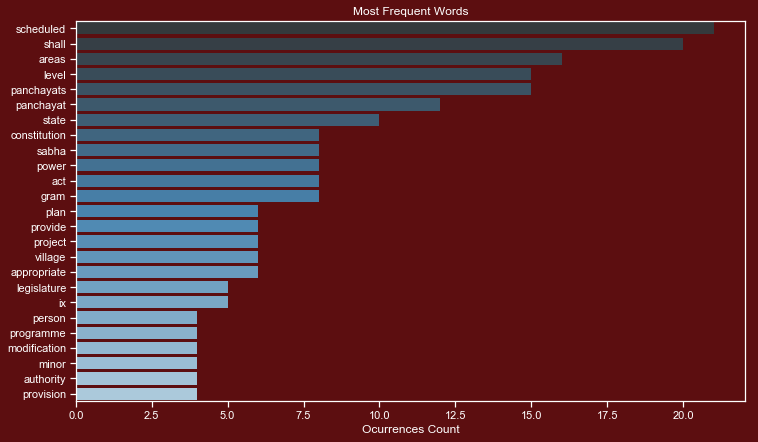

In [229]:
tokens = pd.read_csv(pipeline.tokens_export_path)
words = tokens[(tokens["is_alphabet"] == True) & (tokens["is_stopword"] == False) & (tokens["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()[:25]
sns.barplot(x=words.values, y=words.index, palette="Blues_d", linewidth=0)
plt.xlabel("Ocurrences Count")
plt.title("Most Frequent Words")
plt.show()

In [244]:
data_list = [["text", "score"]]
doc=pipeline.doc
for sent in doc.sents:
    # Only take into account real sentences.
    if len(sent.text) > 10:
        score = 0
        # Start scoring the sentence.
        for word in sent:

            if word.lower_ in positive_words:
                score += 1

            if word.lower_ in negative_words:
                score -= 1

        data_list.append([sent.text, score])

csv.writer(open("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/1.PESA_sentences.csv", "w", encoding="utf-8",
                newline="")).writerows(data_list)

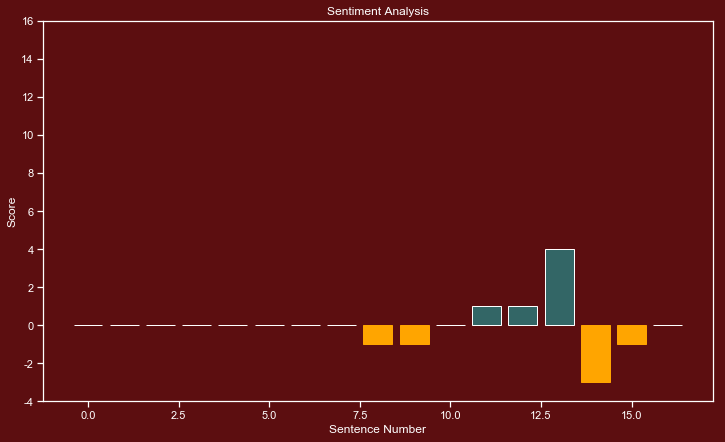

In [245]:
senti = pd.read_csv("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/1.PESA_sentences.csv")
barplot=plt.bar(senti.index, senti["score"], color=(0.2, 0.4, 0.4, 1.0), linewidth=1)
for i in range(len(senti)):
    if senti["score"][i]<0:
        barplot[i].set_color('orange')
yticks_labels = ["{}".format(int(i)) for i in np.arange(-4, 18, 2)]
plt.yticks(np.arange(-4, 18, 2), yticks_labels)
plt.xlabel("Sentence Number")
plt.ylabel("Score")
plt.title("Sentiment Analysis")
plt.show()

# Extract text from pdf document: 2.FRA

In [246]:
filepath = "D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/raw/india/2.FRA.pdf"
doc = Document(filepath) # get_image这里出现过error，需要安装Ghostscript
doc.get_images()
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
doc.process_images()
print("Images processed")
doc.split_lines()
doc.remove_titles()
doc.combine_sentences()
print("Sentences combined")
def window(seq, n):
            "Returns a sliding window (of width n) over data from the iterable"
            "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
            it = iter(seq)
            result = tuple(islice(it, n))
            if len(result) == n:
                yield result
            for elem in it:
                result = result[1:] + (elem,)
                yield result
doc.remove_headers()
print("Text cleaned")
doc.export_data()
print("Exported data to: {}".format(doc.export_path))

Images processed
Removing 187 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/2.FRA.txt


In [247]:
#import en_core_web_sm
#import csv
nlp = en_core_web_sm.load()

#import seaborn as sns
#import matplotlib.pyplot as plt

path="D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/2.FRA.txt"

pipeline=Nlp_pipeline(path)
pipeline.text_token()
pipeline.text_entities()


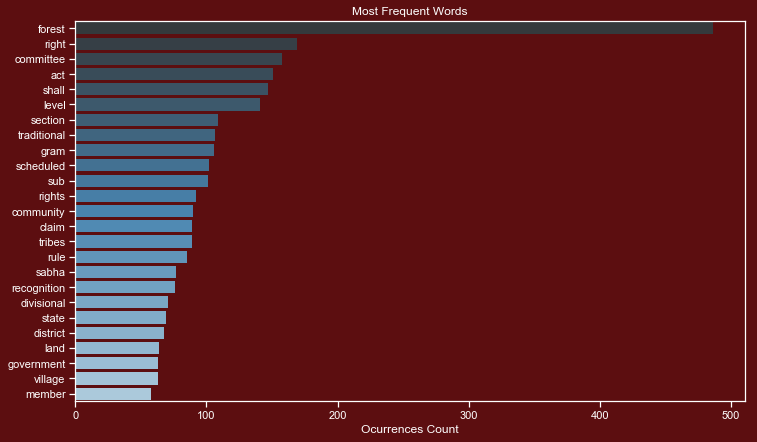

In [248]:
tokens = pd.read_csv(pipeline.tokens_export_path)
words = tokens[(tokens["is_alphabet"] == True) & (tokens["is_stopword"] == False) & (tokens["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()[:25]
sns.barplot(x=words.values, y=words.index, palette="Blues_d", linewidth=0)
plt.xlabel("Ocurrences Count")
plt.title("Most Frequent Words")
plt.show()

In [250]:
data_list = [["text", "score"]]
doc=pipeline.doc
for sent in doc.sents:
    # Only take into account real sentences.
    if len(sent.text) > 10:
        score = 0
        # Start scoring the sentence.
        for word in sent:

            if word.lower_ in positive_words:
                score += 1

            if word.lower_ in negative_words:
                score -= 1

        data_list.append([sent.text, score])

csv.writer(open("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/2.FRA_sentences.csv", "w", encoding="utf-8",
                newline="")).writerows(data_list)

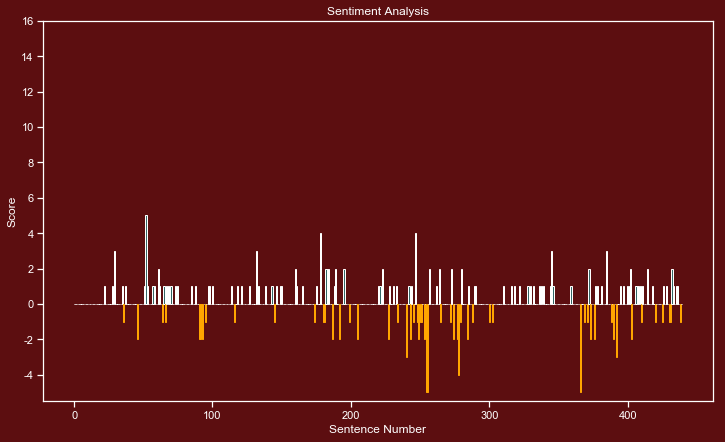

In [251]:
senti = pd.read_csv("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/2.FRA_sentences.csv")
barplot=plt.bar(senti.index, senti["score"], color=(0.2, 0.4, 0.4, 1.0), linewidth=1)
for i in range(len(senti)):
    if senti["score"][i]<0:
        barplot[i].set_color('orange')
yticks_labels = ["{}".format(int(i)) for i in np.arange(-4, 18, 2)]
plt.yticks(np.arange(-4, 18, 2), yticks_labels)
plt.xlabel("Sentence Number")
plt.ylabel("Score")
plt.title("Sentiment Analysis")
plt.show()

# Calculate distance between these two documents

In [299]:
tokens1 = pd.read_csv("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/1.PESA_tokens.csv")
tf1 = tokens1[(tokens1["is_alphabet"] == True) & (tokens1["is_stopword"] == False) & (tokens1["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()

tokens2 = pd.read_csv("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/2.FRA_tokens.csv")
tf2 = tokens2[(tokens2["is_alphabet"] == True) & (tokens2["is_stopword"] == False) & (tokens2["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()

tokens3 = pd.read_csv("D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/india/10.NMSA_Guidelines_English_tokens.csv")
tf3 = tokens3[(tokens3["is_alphabet"] == True) & (tokens3["is_stopword"] == False) & (tokens3["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()

tf1=pd.DataFrame(tf1)
tf2=pd.DataFrame(tf2)
tf3=pd.DataFrame(tf3)

In [311]:
def cos_sim(a,b):
    dot_product=np.dot(a,b)
    norm_a=np.linalg.norm(a)
    norm_b=np.linalg.norm(b)
    return dot_product/(norm_a * norm_b)

def getSimilarity(tf1,tf2):
    all_words_list=[]
    for item in tf1.index:
        all_words_list.append(item)
    for item in tf2.index:
        all_words_list.append(item)
    all_words_list_size = len(all_words_list)
    
    v1=np.zeros(all_words_list_size, dtype=np.int)
    v2=np.zeros(all_words_list_size, dtype=np.int)
    i=0
    for item in all_words_list:
        if item in tf1.index:
            v1[i]=int(tf1[tf1.index==item]["lemma_lower"])
        else:
            v1[i]=0
        if item in tf2.index:
            v2[i]=int(tf2[tf2.index==item]["lemma_lower"])
        else:
            v2[i]=0
        i+=1
    return cos_sim(v1,v2)

In [312]:
getSimilarity(tf1,tf2)

0.42115016257049465

In [313]:
getSimilarity(tf1,tf3)

0.3146671595910213

In [314]:
getSimilarity(tf2,tf3)

0.21417918524592341

In [315]:
getSimilarity(tf1,tf1)

1.0

In [ ]:
text_to_sum = TextSummary(corpus,5)
print(text_to_sum.output())